Generating enhanced GPU temperature patterns with realistic transitions...
241
Generated 45 temperature series across 3 world types
World types: ['cooling', 'heavy', 'idle']


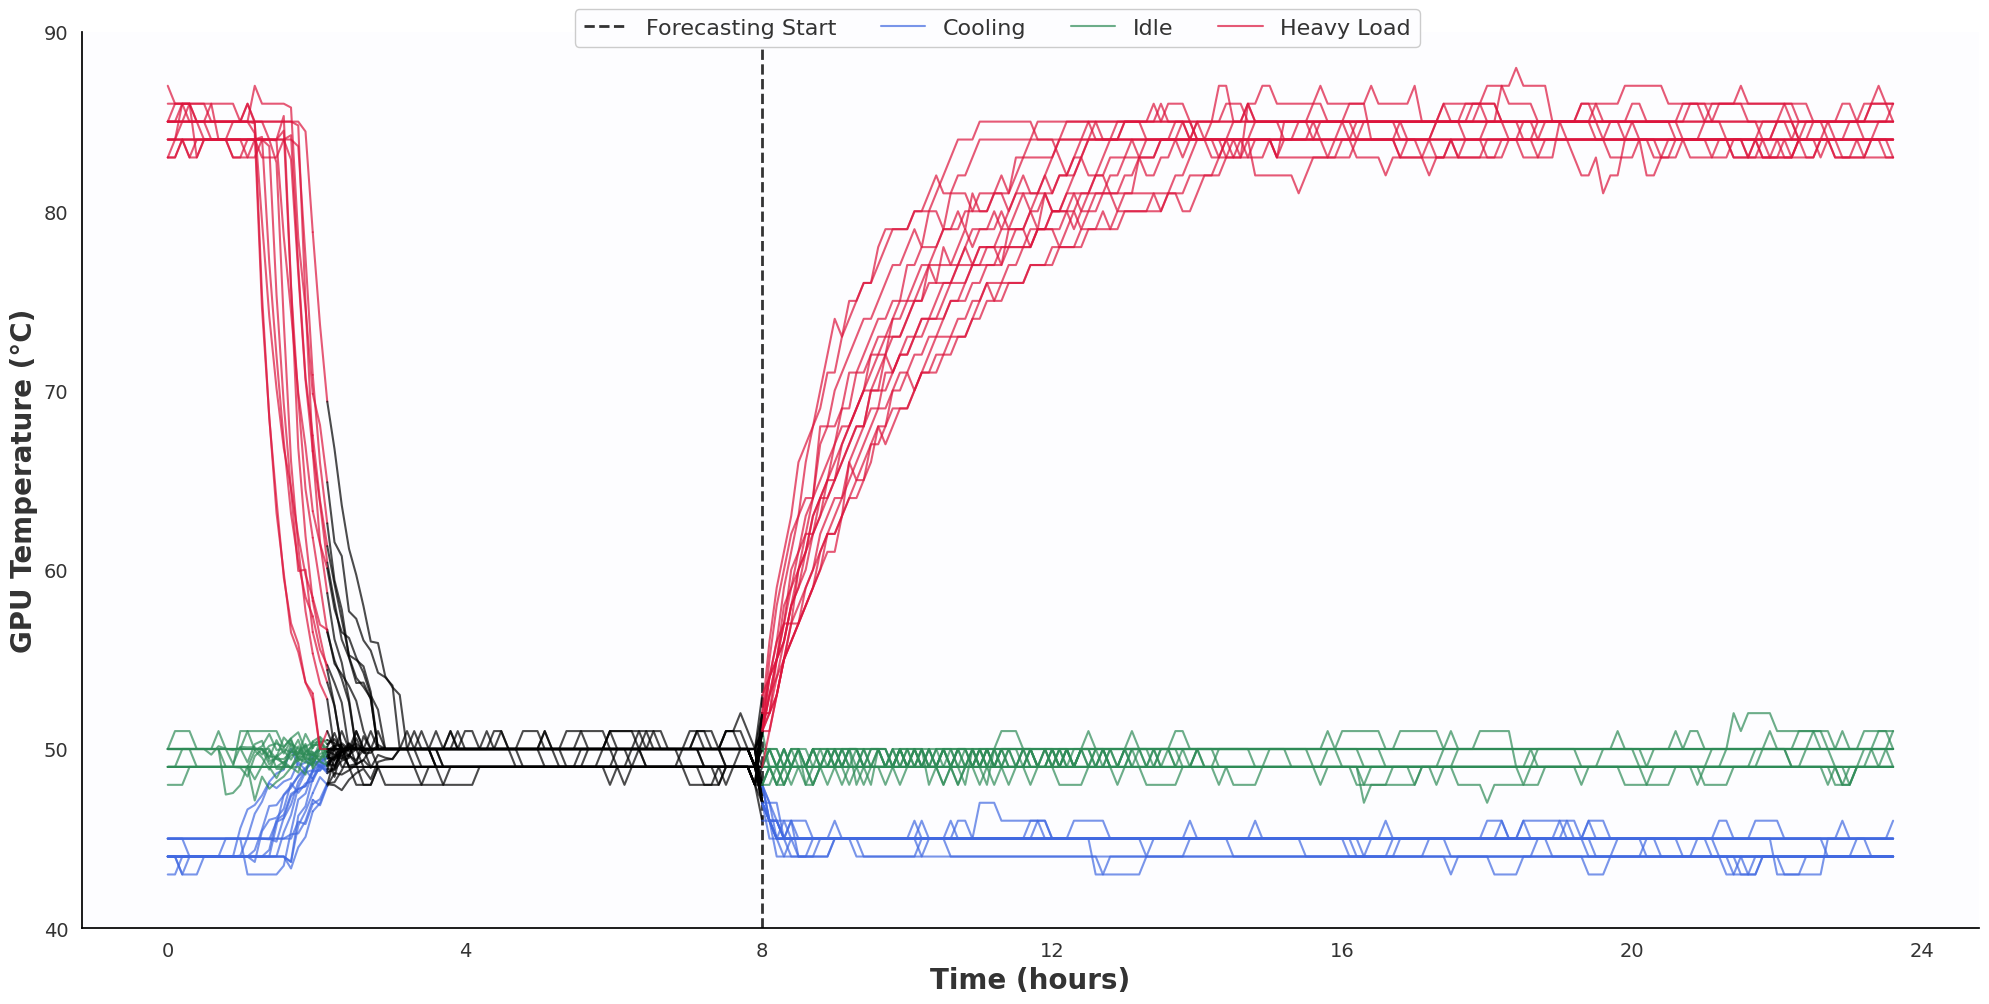

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def poisson_temp_variation(base_temp, n_steps, intensity=0.1):
    """
    Generate temperature variations using Poisson process for realistic modeling.
    
    Args:
        base_temp: Base temperature level
        n_steps: Number of time steps
        intensity: Rate parameter for Poisson process (lower = more stable)
    
    Returns:
        Array of integer temperatures
    """
    # Generate Poisson events for temperature changes
    events = np.random.poisson(intensity, n_steps)
    
    # Convert events to temperature deltas (can be positive or negative)
    temp_deltas = np.where(np.random.random(n_steps) > 0.5, events, -events)
    
    # Apply random walk with mean reversion to base temperature
    temperatures = np.zeros(n_steps)
    temperatures[0] = base_temp
    
    for i in range(1, n_steps):
        # Mean reversion factor (pulls back to base_temp)
        reversion = 0.1 * (base_temp - temperatures[i-1])
        # New temperature with Poisson variation and mean reversion
        temperatures[i] = temperatures[i-1] + temp_deltas[i] + reversion
    
    # Ensure temperatures stay within realistic bounds and are integers
    temperatures = np.clip(temperatures, 25, 105)  # Physical limits
    return temperatures.astype(int)

def create_enhanced_worlds(n_realizations_per_world=5):
    """
    Create multiple realizations of different GPU states with realistic patterns.
    
    Args:
        n_realizations_per_world: Number of different realizations per world type
    
    Returns:
        Dictionary with world types and their temperature series
    """
    n_steps = 10 * 18  # 18 * 10-minute intervals = 3 hours
    worlds = {}
    
    # Cooling state: stable around 45°C 
    worlds['cooling'] = []
    for i in range(n_realizations_per_world):
        temp_series = poisson_temp_variation(45, n_steps, intensity=0.03)
        worlds['cooling'].append(temp_series)
    
    # Idle state: stable around 50°C with minimal variation
    worlds['idle'] = []
    for i in range(n_realizations_per_world):
        temp_series = poisson_temp_variation(50, n_steps, intensity=0.05)
        worlds['idle'].append(temp_series)
    
    # Heavy load: high temperature around 85°C with more variation
    worlds['heavy_load'] = []
    for i in range(n_realizations_per_world):
        temp_series = poisson_temp_variation(85, n_steps, intensity=0.12)
        worlds['heavy_load'].append(temp_series)
    
    return worlds

def create_very_gradual_transition(start_temp, end_temp, n_steps, transition_type='very_gradual'):
    """
    Create very realistic and slow temperature transitions after breaking point.
    
    Args:
        start_temp: Starting temperature
        end_temp: Target temperature
        n_steps: Number of steps for transition
        transition_type: 'very_gradual', 'gradual', 'sudden'
    
    Returns:
        Array of transition temperatures
    """
    if transition_type == 'sudden':
        # Quick transition (5-8 steps)
        transition_steps = min(np.random.randint(5, 9), n_steps)
        transition = np.linspace(start_temp, end_temp, transition_steps)
        # Fill remaining steps with target temp + small variations
        remaining = np.ones(n_steps - transition_steps) * end_temp
        remaining += np.random.normal(0, 0.8, len(remaining))
        return np.concatenate([transition, remaining])
    
    elif transition_type == 'gradual':
        # Moderate exponential-like transition
        t = np.linspace(0, 1, n_steps)
        # Exponential approach to target
        transition = start_temp + (end_temp - start_temp) * (1 - np.exp(-2.5 * t))
        # Add some noise
        transition += np.random.normal(0, 0.4, n_steps)
        return transition
    
    else:  # very_gradual - much slower temperature change
        # Very slow exponential transition with multiple phases
        t = np.linspace(0, 1, n_steps)
        
        # Multi-phase transition: initial slow rise, then plateau, then gradual approach
        phase1 = t < 0.3
        phase2 = (t >= 0.3) & (t < 0.7)
        phase3 = t >= 0.7
        
        transition = np.zeros_like(t)
        
        # Phase 1: Very slow initial rise (30% of time, 20% of temperature change)
        temp_change = end_temp - start_temp
        transition[phase1] = start_temp + 0.2 * temp_change * (1 - np.exp(-1.5 * t[phase1] / 0.3))
        
        # Phase 2: Plateau with minor fluctuations (40% of time, 30% of temperature change)
        phase2_start = transition[phase1][-1] if np.any(phase1) else start_temp
        t_phase2 = (t[phase2] - 0.3) / 0.4
        transition[phase2] = phase2_start + 0.3 * temp_change * (1 - np.exp(-1.0 * t_phase2))
        
        # Phase 3: Final gradual approach (30% of time, remaining 50% of temperature change)
        phase3_start = transition[phase2][-1] if np.any(phase2) else start_temp
        t_phase3 = (t[phase3] - 0.7) / 0.3
        transition[phase3] = phase3_start + (end_temp - phase3_start) * (1 - np.exp(-1.8 * t_phase3))
        
        # Add realistic noise that decreases over time
        noise_amplitude = np.linspace(0.8, 0.3, n_steps)
        transition += np.random.normal(0, noise_amplitude, n_steps)
        
        return transition

def create_smooth_connecting_transition(temp1, temp2, n_steps=3):
    """
    Create a smooth connecting transition between two temperature points.
    
    Args:
        temp1: Starting temperature
        temp2: Ending temperature  
        n_steps: Number of steps for the connection (default 3 for smooth curve)
    
    Returns:
        Array of connecting temperatures
    """
    if n_steps <= 1:
        return np.array([temp2])
    
    # Use a smooth sigmoid-like transition
    t = np.linspace(0, 1, n_steps)
    # Smooth S-curve transition
    smooth_curve = 3 * t**2 - 2 * t**3  # Smooth step function
    transition = temp1 + (temp2 - temp1) * smooth_curve
    
    # Add minimal noise for realism
    transition += np.random.normal(0, 0.2, n_steps)
    
    return transition.astype(int)

def create_enhanced_series_with_breaking_point(n_realizations_per_world=5):
    """
    Create complete temperature series with breaking point structure and realistic transitions:
    [last 20 steps of world] + [smooth connection] + [prefix] + [very gradual transition] + [remaining world steps]
    """
    worlds_data = create_enhanced_worlds(n_realizations_per_world)

    # Prefix: standard idle state (6 * 10-minute intervals = 1 hour)
    prefix_steps = 10 * 6

    all_series = []
    series_labels = []

    for world_type, realizations in worlds_data.items():
        for i, world_series in enumerate(realizations):
            # Extract last 20 steps of the world
            last_20_steps = world_series[-20:]

            # Create prefix with slight variations
            prefix = poisson_temp_variation(50, prefix_steps, intensity=0.04)
            
            if world_type == 'cooling':
                transition_steps = min(
                    np.random.randint(4, 8), 
                    8
                )
            else:
                max_transition_steps = int(0.4 * len(remaining_world_original))
                min_transition_steps = int(0.15 * len(remaining_world_original))
                transition_steps = min(
                    np.random.randint(min_transition_steps, max_transition_steps + 1), 
                    len(remaining_world_original)
                )

            transition_type = 'gradual'
            # --- FIX: Smooth transition between last_20_steps and prefix ---
            steps = np.random.randint(8, 16)
            transition_to_prefix = create_very_gradual_transition(
                last_20_steps[-1], prefix[0], steps, transition_type
            )
            _start = np.random.randint(1, steps)
            # Combine last_20 + transition + prefix
            combined_prefix_section = np.concatenate([
                last_20_steps[:_start-steps], transition_to_prefix, prefix[_start-1:]
            ])

            # Remaining world steps (excluding last 20)
            remaining_world_original = world_series[:-20]

            # Create very gradual transition from end of prefix to beginning of world
            prefix_end_temp = combined_prefix_section[-1]
            world_target_temp = np.mean(remaining_world_original[:20])


            transition = create_very_gradual_transition(
                prefix_end_temp, world_target_temp, transition_steps, transition_type
            )

            if transition_steps < len(remaining_world_original):
                remaining_original = remaining_world_original[transition_steps:]
                blend_steps = min(5, len(remaining_original))
                if blend_steps > 0:
                    blend_weights = np.linspace(0, 1, blend_steps)
                    remaining_original[:blend_steps] = (
                        (1 - blend_weights) * transition[-1] + 
                        blend_weights * remaining_original[:blend_steps]
                    )
                remaining_world = np.concatenate([transition, remaining_original])
            else:
                remaining_world = transition[:len(remaining_world_original)]

            remaining_world = np.clip(remaining_world, 25, 105).astype(int)

            complete_series = np.concatenate([
                combined_prefix_section, remaining_world
            ])

            all_series.append(complete_series)
            series_labels.append(f"{world_type}_{i+1}")

    return all_series, series_labels

def plot_temperature_patterns(series, labels):
    """
    Plot temperature patterns with clean visualization.
    """
    custom_text_color = "#333333"
    custom_bg = "#FDFDFF"
    
    custom_theme = {
        'axes.facecolor': custom_bg,
        'axes.edgecolor': 'black',
        'axes.grid': False,
        'grid.color': '#dcdcdc',
        'grid.linestyle': '-',
        'xtick.color': custom_text_color,
        'ytick.color': custom_text_color,
        'axes.labelcolor': custom_text_color,
        'text.color': custom_text_color
    }
    sns.set_theme(style='white')
    sns.set_style("white", rc=custom_theme)
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Define time axis (10-minute intervals)
    time_minutes = np.arange(len(series[0])-2) * 10
    time_hours = time_minutes / 60
    
    # Mark the breaking point (after last 20 steps + connection + prefix)
    connection_steps = 2
    prefix_steps = 10 * 6
    breaking_point_hours = (20 + connection_steps + prefix_steps) * 10 / 60  # Convert to hours
    ax.axvline(x=breaking_point_hours, color='black', linestyle='--', 
               alpha=0.8, linewidth=2, label='Forecasting Start')
    
    # Define colors for different world types
    world_colors = {
        'cooling': '#4169E1',    # Royal Blue
        'idle': '#2E8B57',      # Sea Green
        'heavy': '#DC143C'  # Crimson
    }
    
    # Plot each series
    for i, (temp_series, label) in enumerate(zip(series, labels)):
        world_type = label.split('_')[0]
        color = world_colors.get(world_type, 'gray')
        alpha = 0.7
        # temp_series = temp_series[0:248]

        
        # Plot different segments - all in the same color for each world type
        # Segment 1: Last 20 steps (pre-history)
        ax.plot(time_hours[:21], temp_series[:21], 
                color=color, alpha=alpha, linewidth=1.5, label=f'{world_type}' if i % 5 == 0 else "")
        
        # Segment 2: Connection (smooth transition)
        connection_start = 20
        connection_end = 20 + connection_steps
        ax.plot(time_hours[connection_start:connection_end+1], 
                temp_series[connection_start:connection_end+1], 
                color=color, alpha=alpha, linewidth=1.5)
        
        # Segment 3: Prefix (idle period)
        prefix_start = connection_end
        prefix_end = prefix_start + prefix_steps
        ax.plot(time_hours[prefix_start:prefix_end+1], 
                temp_series[prefix_start:prefix_end+1], 
                color='black', alpha=alpha, linewidth=1.5)
        
        # Segment 4: Post-breaking point (gradual transition to world state)
        ax.plot(time_hours[prefix_end:], temp_series[prefix_end:prefix_end+len(time_hours[prefix_end:])], 
                color=color, alpha=alpha, linewidth=1.5)
    # print(time_hours)
    xticks=[0, 40/24 *4+0.166666666666666]+[40/24 *i+0.33333333333333 for i in [8, 12, 16, 20, 24]] #[i * 6 for i in time_hours]
    xlabels=[0, 4, 8, 12, 16, 20, 24] #[i for i in time_hours]
    plt.xticks(xticks, xlabels)
    ax.set_xlabel('Time (hours)', fontsize=20, fontweight='bold')
    ax.set_ylabel('GPU Temperature (°C)', fontsize=20, fontweight='bold')
    # ax.set_title('GPU Temperature Patterns: Cooling, Idle, and Heavy Load Scenarios', 
                 # fontsize=16, fontweight='bold')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
    
    # Set temperature range
    ax.set_ylim(40, 90)
    
    # Improve overall plot appearance
    plt.tight_layout()
    sns.despine(left=False, bottom=False)
    # Create a single legend for the entire figure
    # Collect handles and labels from the last subplot (they should be consistent across all subplots)
    handles, labels = ax.get_legend_handles_labels()
    handles = [handles[i] for i in [0, 1, 4, 7]]
    labels = [labels[i] for i in [0]]+ ['Cooling', 'Idle', 'Heavy Load']
    # Place the legend outside the subplots
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), 
              bbox_to_anchor=(0.5, 0.95), fontsize=16, frameon=True, framealpha=1)
    ax.tick_params(axis='both', labelsize=14)
    return fig, ax
import random

SEED = 37
np.random.seed(SEED)
random.seed(SEED)
# Generate the enhanced temperature patterns with more series
print("Generating enhanced GPU temperature patterns with realistic transitions...")
series, labels = create_enhanced_series_with_breaking_point(n_realizations_per_world=15)
print(len(series[0]))
print(f"Generated {len(series)} temperature series across {len(set([l.split('_')[0] for l in labels]))} world types")
print(f"World types: {sorted(set([l.split('_')[0] for l in labels]))}")

# Create the plot
fig, ax = plot_temperature_patterns(series, labels)
plt.savefig("GPU_example.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

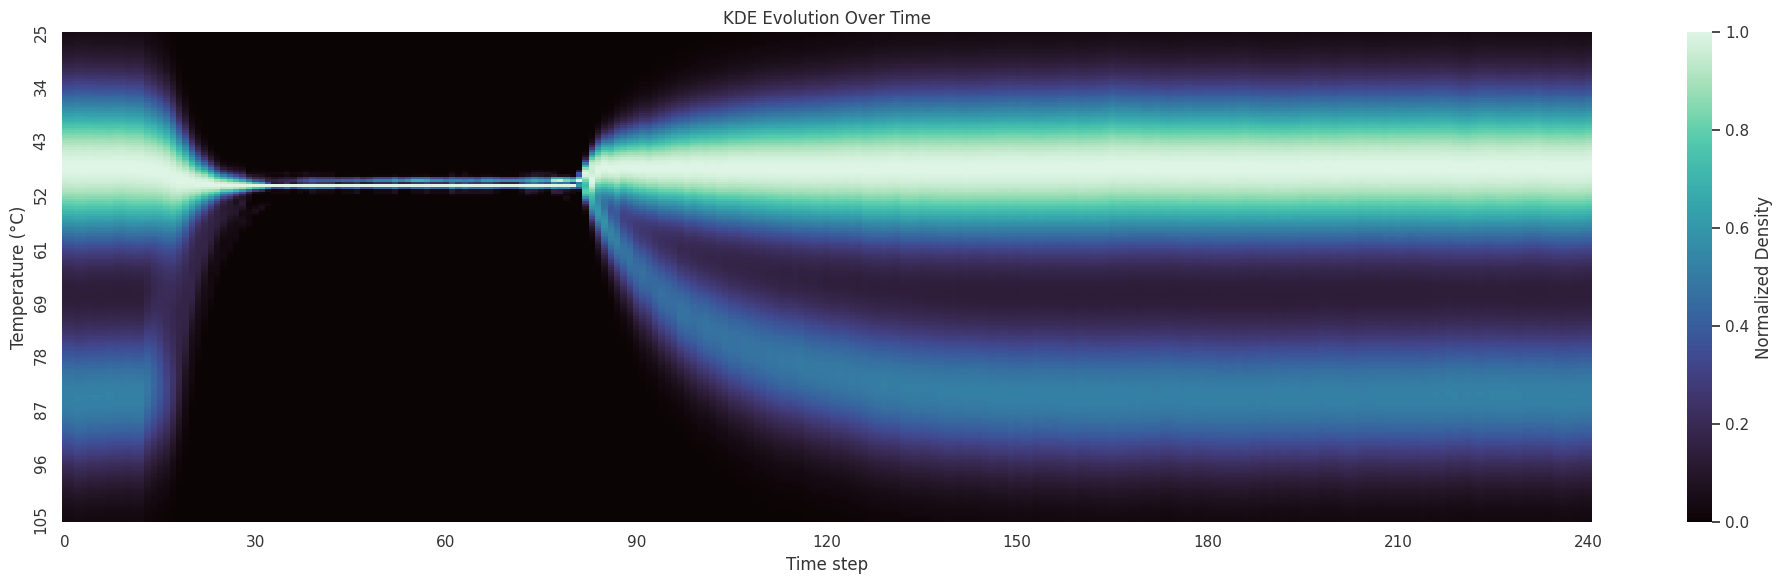

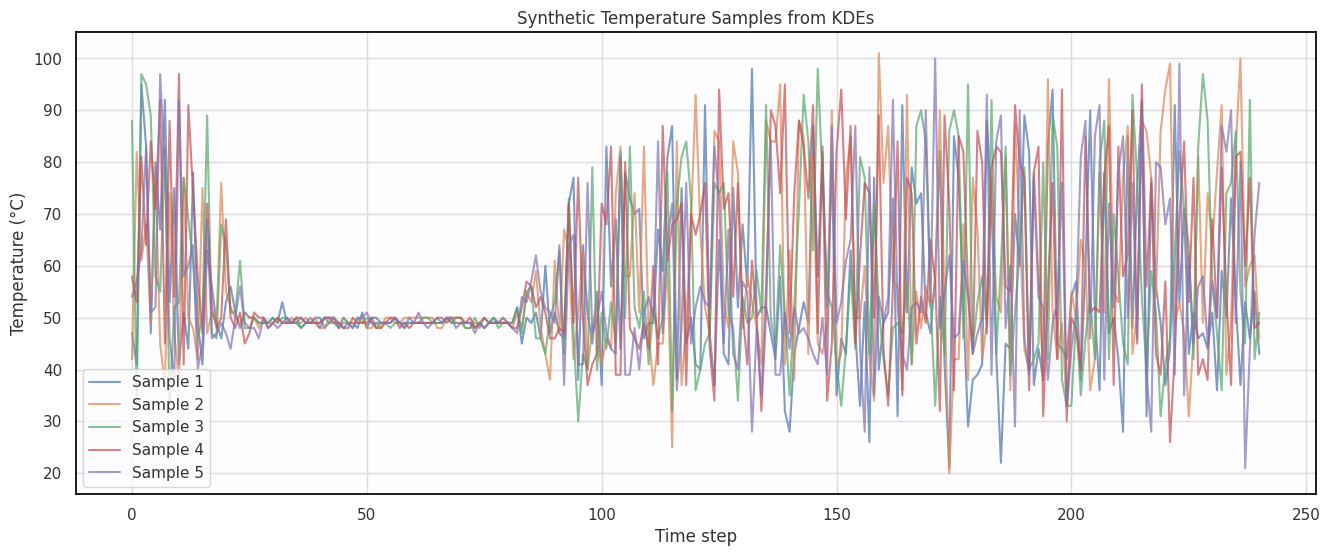

In [2]:
from scipy.stats import gaussian_kde

def fit_kde_over_time(series, bandwidth='scott'):
    """
    Fit a KDE over all temperature series at each time step.

    Args:
        series: List of temperature series
        bandwidth: Bandwidth method for KDE

    Returns:
        List of gaussian_kde objects, one per time step
    """
    series = np.array(series)
    n_steps = series.shape[1]
    kde_models = []
    for t in range(n_steps):
        temp_at_t = series[:, t]
        kde = gaussian_kde(temp_at_t, bw_method=bandwidth)
        kde_models.append(kde)
    return kde_models

def plot_kde_heatmap(kde_models, temp_range=(25, 105), resolution=200):
    """
    Plot KDEs over time as a 2D heatmap.

    Args:
        kde_models: List of KDEs at each time step
        temp_range: Tuple (min_temp, max_temp)
        resolution: Number of temperature points in vertical axis
    """
    temperatures = np.linspace(*temp_range, resolution)
    kde_grid = np.zeros((resolution, len(kde_models)))

    for t, kde in enumerate(kde_models):
        kde_values = kde(temperatures)
        kde_grid[:, t] = kde_values / kde_values.max()  # Normalize for visualization

    plt.figure(figsize=(20, 6))
    sns.heatmap(kde_grid, xticklabels=30, yticklabels=20, cmap="mako", cbar_kws={"label": "Normalized Density"})
    plt.xlabel("Time step")
    plt.ylabel("Temperature (°C)")
    yticks = np.linspace(0, resolution - 1, 10).astype(int)
    ylabels = np.round(np.linspace(*temp_range, 10)).astype(int)
    plt.yticks(yticks, ylabels)
    plt.title("KDE Evolution Over Time")
    plt.tight_layout()
    plt.show()

def sample_from_kdes(kde_models, n_samples=1):
    """
    Sample synthetic temperature paths from the sequence of KDEs.

    Args:
        kde_models: List of KDEs over time
        n_samples: Number of synthetic series to generate

    Returns:
        np.ndarray of shape (n_samples, time_steps)
    """
    time_steps = len(kde_models)
    samples = np.zeros((n_samples, time_steps))
    for t, kde in enumerate(kde_models):
        samples[:, t] = kde.resample(n_samples).flatten()
    return samples.astype(int)

# === Example usage ===
kde_models = fit_kde_over_time(series)
plot_kde_heatmap(kde_models)
synthetic_paths = sample_from_kdes(kde_models, n_samples=5)

# Optional: visualize synthetic paths
plt.figure(figsize=(16, 6))
for i in range(synthetic_paths.shape[0]):
    plt.plot(synthetic_paths[i], label=f'Sample {i+1}', alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")
plt.title("Synthetic Temperature Samples from KDEs")
plt.legend()
plt.grid(True)
plt.show()


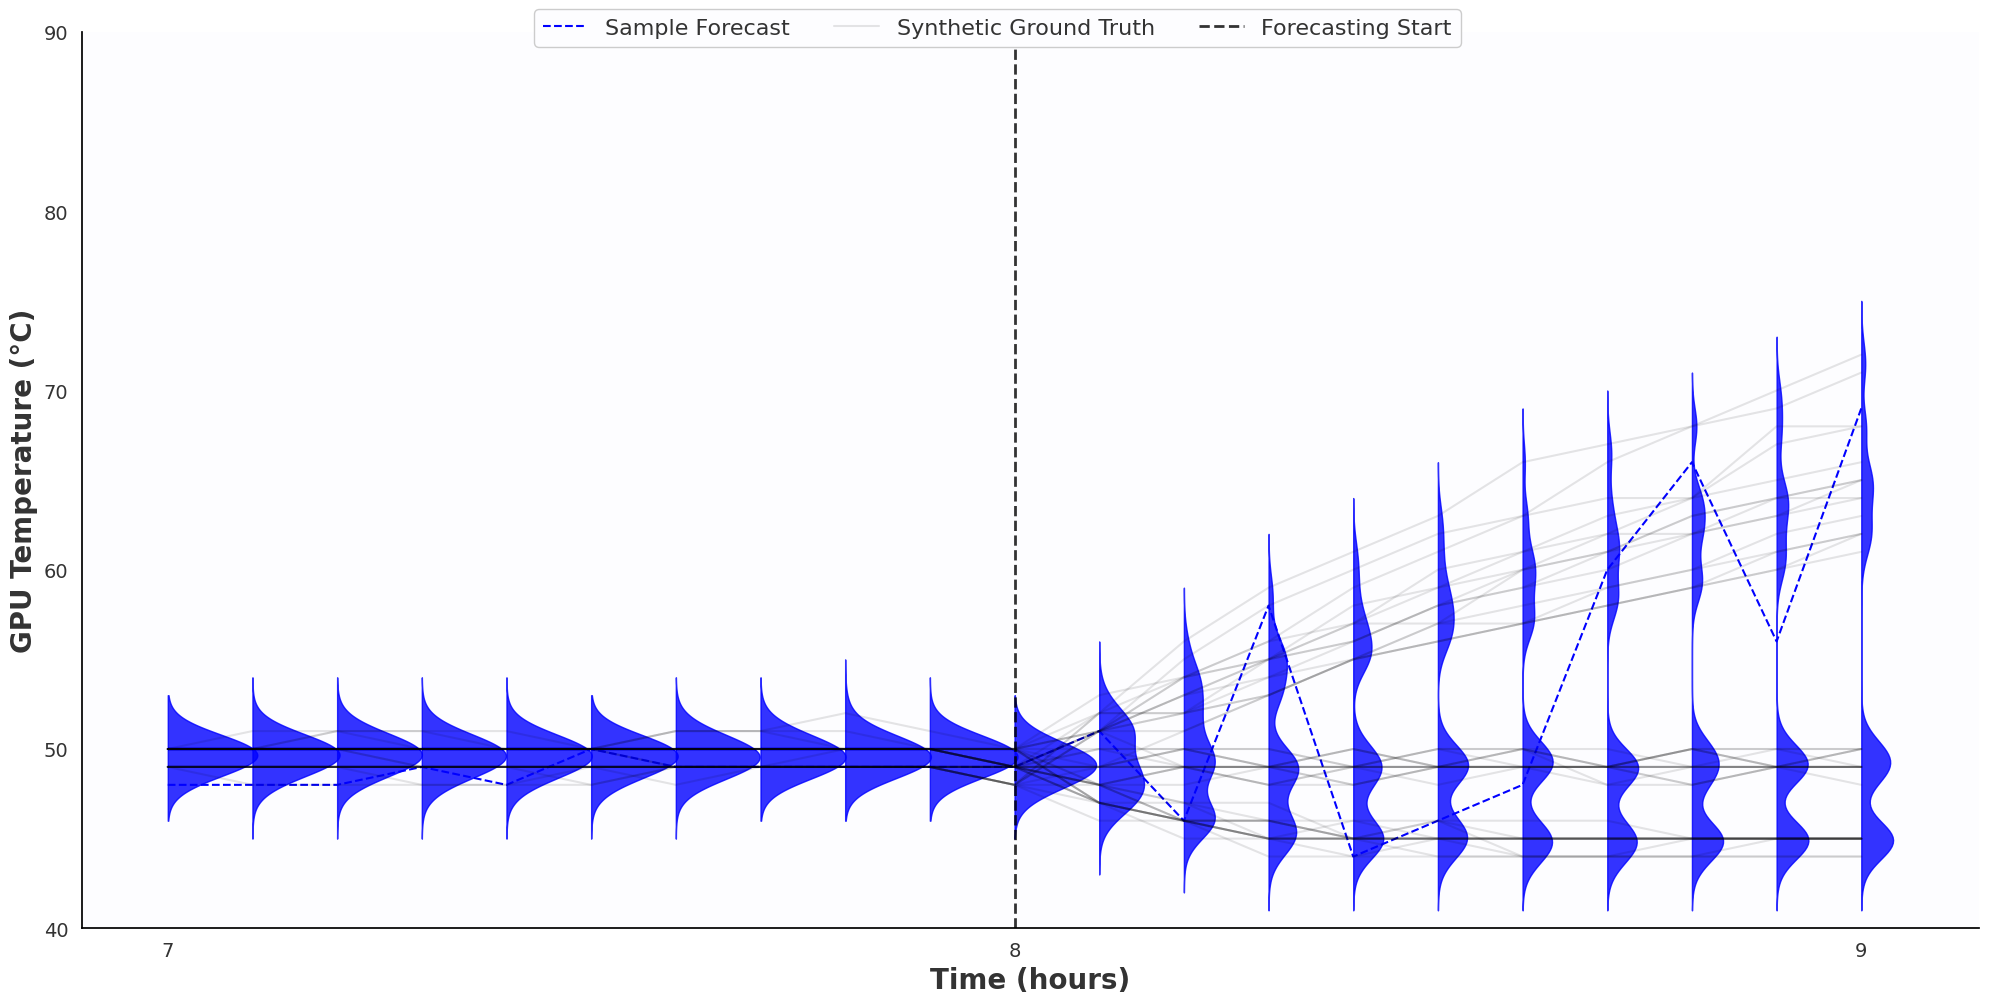

In [27]:
from scipy.stats import gaussian_kde

def overlay_vertical_kde(series, ax, scale=0.2, color='gray', alpha=0.25, bandwidth=1.0):
    """
    Overlay vertical KDE bell curves centered at each time step.

    Args:
        series: 2D array (n_series x n_timesteps)
        ax: Matplotlib axis
        scale: Horizontal scale of the KDE bell curve
        color: Color of the KDE fill
        alpha: Transparency of the fill
        bandwidth: Bandwidth scaling for KDE
    """
    series = np.array(series)
    n_steps = series.shape[1]

    for t in range(n_steps):
        temps_at_t = series[:, t]

        # Skip KDE if there's no variance
        if np.std(temps_at_t) == 0:
            continue

        # Fit KDE
        kde = gaussian_kde(temps_at_t, bw_method=bandwidth / np.std(temps_at_t))
        y_vals = np.linspace(temps_at_t.min() - 3, temps_at_t.max() + 3, 200)
        densities = kde(y_vals)

        # Horizontal (x) positions scaled by density and centered at time t
        x_center = t * 10 / 60.0  # time in hours
        x_vals = x_center + densities * scale  # right edge
        x_vals_mirror = x_center - densities * scale  # left edge

        # Fill between left and right to form full bell curve
        # ax.fill_betweenx(y_vals, x_vals_mirror, x_vals, color=color, alpha=alpha)
        ax.fill_betweenx(y_vals, x_center, x_vals, color=color, alpha=alpha)


# === Example usage ===
# kde_models = fit_kde_over_time(series)
# plot_kde_heatmap(kde_models)
synthetic_paths = sample_from_kdes(kde_models, n_samples=20)

start = 170
end = 149
custom_text_color = "#333333"
custom_bg = "#FDFDFF"

custom_theme = {
    'axes.facecolor': custom_bg,
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.color': '#dcdcdc',
    'grid.linestyle': '-',
    'xtick.color': custom_text_color,
    'ytick.color': custom_text_color,
    'axes.labelcolor': custom_text_color,
    'text.color': custom_text_color
}
sns.set_theme(style='white')
sns.set_style("white", rc=custom_theme)
fig, ax = plt.subplots(figsize=(20, 10))  # This gives you an axis to work with
for i in range(1):
    ax.plot(np.arange(start-end) * 10 / 60, synthetic_paths[i][-start:-end], color='blue', alpha=1, linestyle='--', label="Sample Forecast")

s = np.array(series)
for i in range(s.shape[0]):
    if i==0:
        ax.plot(np.arange(start-end) * 10 / 60, s[i][-start:-end], color='black', alpha=0.1, label="Synthetic Ground Truth")
    else:
        ax.plot(np.arange(start-end) * 10 / 60, s[i][-start:-end], color='black', alpha=0.1)

xticks=[0, 1.6666667, 40/24 *2] # [0, 40/24 *4+0.166666666666666]+[40/24 *i+0.33333333333333 for i in [8, 12, 16, 20, 24]] #[i * 6 for i in time_hours]
xlabels=[7, 8, 9] #[0, 4, 8, 12, 16, 20, 24] #[i for i in time_hours]
plt.xticks(xticks, xlabels)
ax.set_xlabel('Time (hours)', fontsize=20, fontweight='bold')
ax.set_ylabel('GPU Temperature (°C)', fontsize=20, fontweight='bold')
# ax.set_title("Synthetic Temperature Samples from KDEs")
# Set temperature range
ax.set_ylim(40, 90)
breaking_point_hours = 1.666667 #(20 + connection_steps + prefix_steps) * 10 / 60  # Convert to hours
ax.axvline(x=breaking_point_hours, color='black', linestyle='--', 
           alpha=0.8, linewidth=2, label='Forecasting Start')
# Improve overall plot appearance
plt.tight_layout()
sns.despine(left=False, bottom=False)
# Create a single legend for the entire figure
# Collect handles and labels from the last subplot (they should be consistent across all subplots)
handles, labels = ax.get_legend_handles_labels()
# handles = [handles[i] for i in [0, 1, 4, 7]]
# labels = [labels[i] for i in [0, 1, 4]]+ ['heavy load']
# # Place the legend outside the subplots
fig.legend(handles, labels, loc='lower center', ncol=len(labels), 
          bbox_to_anchor=(0.5, 0.95), fontsize=16, frameon=True, framealpha=1)
ax.tick_params(axis='both', labelsize=14)

overlay_vertical_kde(np.array(series)[:, -start:-end], ax, scale=0.5, color='blue', alpha=0.8)
plt.savefig("DMS_fails.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

In [4]:
print(np.array(series).shape)

(45, 241)
